In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U nltk # To Upgrade NLTK to >3.5 for METEOR score

     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████████████████████████| 749 kB 38.0 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk

print('The nltk version is {}.'.format(nltk.__version__)) # Verify version >3.5

The nltk version is 3.7.


In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
!pip install sumy rouge
import re

import pandas as pd

from pathlib import Path

from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from rouge import Rouge


     |████████████████████████████████| 87 kB 3.5 MB/s 
     |████████████████████████████████| 10.1 MB 29.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21712 sha256=e0048e19aea0852b9a76933f123e6f9d9bdc79059f9982a23232dae0ebfc3dfd
  Stored in directory: /root/.cache/pip/wheels/d4/bf/51/81d27ad638e1a6dca4f362ecc33d1e2c764b8ea7ec751b8fc1
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=8c3640d395fdc0b7fdf37514ffebec5062cb71b725dbd32eb95e5656499b5c5f
  Stored in directory: /root/.cache/pip/wheels/0e/06/e8/7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built breadability pycountry


In [ ]:
def extract(filepath):
    pattern = r'(\w+)/(\d+)\.txt$'
    category, file_id = re.search(pattern, str(filepath)).groups()
    with open(filepath, 'r', encoding='unicode_escape') as f:
        text = f.read()
        return category, file_id, text


In [ ]:
dataset_path = Path('/content/drive/MyDrive/NLP/BBC News Summary/')

articles_data = list(map(extract, dataset_path.glob('News Articles/*/*.txt')))
summaries_data = list(map(extract, dataset_path.glob('Summaries/*/*.txt')))

articles_df = pd.DataFrame(articles_data, columns=('Category', 'ID', 'text'))
summaries_df = pd.DataFrame(summaries_data, columns=('Category', 'ID', 'summary'))

pre_data = articles_df.merge(summaries_df, how='inner', on=('Category', 'ID'))

In [ ]:
pre_data.head()
pre_data.drop('Category', axis=1, inplace=True)
pre_data.drop('ID', axis=1, inplace=True)
pre_data.head()
pre_data['text'][:15]

0     Supercomputer breaks speed record\n\nThe US is...
1     Blind student 'hears in colour'\n\nA blind stu...
2     Broadband fuels online change\n\nFast web acce...
3     Apple Mac mini gets warm welcome\n\nThe Mac mi...
4     Sony PSP handheld console hits US\n\nThe lates...
5     Apple sues 'Tiger' file sharers\n\nApple has t...
6     Games maker fights for survival\n\nOne of Brit...
7     Halo 2 heralds traffic explosion\n\nThe growin...
8     Musical future for phones\n\nAnalyst Bill Thom...
9     Media gadgets get moving\n\nPocket-sized devic...
10    Nintendo DS aims to touch gamers\n\nThe mobile...
11    Consumer concern over RFID tags\n\nConsumers a...
12    Yahoo celebrates a decade online\n\nYahoo, one...
13    Robots learn 'robotiquette' rules\n\nRobots ar...
14    New consoles promise big problems\n\nMaking ga...
Name: text, dtype: object

**Seq2Seq GRUModelling**

In [ ]:
pre_data['text'][:10]

0    Supercomputer breaks speed record\n\nThe US is...
1    Blind student 'hears in colour'\n\nA blind stu...
2    Broadband fuels online change\n\nFast web acce...
3    Apple Mac mini gets warm welcome\n\nThe Mac mi...
4    Sony PSP handheld console hits US\n\nThe lates...
5    Apple sues 'Tiger' file sharers\n\nApple has t...
6    Games maker fights for survival\n\nOne of Brit...
7    Halo 2 heralds traffic explosion\n\nThe growin...
8    Musical future for phones\n\nAnalyst Bill Thom...
9    Media gadgets get moving\n\nPocket-sized devic...
Name: text, dtype: object

> **Perform Data Cleansing**

In [ ]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #delete escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #delete _ if more than one time repeatedly
        row=re.sub("(--+)", ' ', str(row)).lower()   #delete - if more than one time repeatedly
        row=re.sub("(~~+)", ' ', str(row)).lower()   #delete ~ if more than one time repeatedly
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #delete + if more than one time repeatedly
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #delete . if more than one time repeatedly
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #delete <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #delete mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #delete \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #delete full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #delete - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #delete : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #delete any single charecters hanging between 2 spaces
        
        # Change url http://www.youtube.com/watch/43865346kcre8375 ====> www.youtube.com
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #delete multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #delete any single charecters hanging between 2 spaces

        
        
        yield row




In [ ]:
cleaning1 = text_strip(pre_data['text'])
cleaning2 = text_strip(pre_data['summary'])

In [ ]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) 

t = time()

text = [str(doc) for doc in nlp.pipe(cleaning1, batch_size=5000, n_threads=-1)] #spaCy.pipe() to speed-up cleaning 

#Takes 40 mins
print('Cleaning time for text: {} mins'.format(round((time() - t) / 60, 2)))

Cleaning time for text: 0.8 mins


In [ ]:
t = time()

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(cleaning2, batch_size=5000, n_threads=-1)]

#Takes 40 mins
print('Cleaning time for summary: {} mins'.format(round((time() - t) / 60, 2)))

Cleaning time for summary: 0.23 mins


In [ ]:
text[0]

'supercomputer breaks speed record the us is poised to push japan off the top of the supercomputing chart with ibm prototype blue gene/l machine it is being assembled for the lawrence livermore national laboratory us department of energy doe lab doe test results show that blue gene/l has managed speeds of 70.72 teraflops the current top machine japan nec earth simulator clocks up 35.86 due next week the top 500 list officially charts the fastest computers in the world it is announced every six months and is worked out using an officially recognised mathematical speed test called linpack which measures calculations per second the speeds will most likely make it the fastest computer system on the planet yet the chip technology powering the machine is the kind which can be found in familiar devices such as games consoles the us secretary of energy spencer abraham confirmed that the machine had reached the breakneck speed according to the linpack benchmark until the official list is publis

In [ ]:
summary[0]

'_START_ the us is poised to push japan off the top of the supercomputing chart with ibm prototype blue gene/l machine.but in september ibm said that another blue gene/l machine clocked up 36.01 teraflops marginally surpassing the earth simulator performance.doe test results show that blue gene/l has managed speeds of 70.72 teraflops.the linux-based machine was reported to have reached top speed of 42.7 teraflops in october.one area where mr donofrio sees supercomputing and blue gene machines in particular as crucial is health.the ibm blue gene/l is only prototype and is one 5th the speed of the full version due to be completed for the livermore labs in 2005.the blue gene/l machine that will be completed next year will be five million times faster.compared with the current fastest supercomputers blue gene is designed to consume one 15th the power and be 10 times more compact.the current top machine japan nec earth simulator clocks up 35.86.since the first supercomputer the cray-1 was i

###Save the clean data to files  

In [ ]:
with open('/content/drive/MyDrive/NLP/text.txt', "w") as f:
  for item in text:
    f.write(item + '\n')

with open('/content/drive/MyDrive/NLP/summary.txt', "w") as f:
  for item in summary:
    f.write(item + '\n')

###Read clean data from files

In [ ]:
text1 = []
summary1 = []
text = []
summary = []

with open('/content/drive/MyDrive/NLP/text.txt', "r") as f:
  for line in f.readlines():
    text1.append(line)

with open('/content/drive/MyDrive/NLP/summary.txt', "r") as f:
  for line in f.readlines():
    summary1.append(line)

for item in text1:
  text.append(item.replace('\n', ''))

for item in summary1:
  summary.append(item.replace('\n', ''))

In [ ]:
pre_data['cleaned_text'] = pd.Series(text)
pre_data['cleaned_summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre_data['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre_data['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

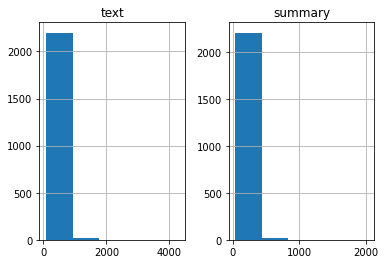

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Check how much % of summary have 0-15 words
count=0
for i in pre_data['cleaned_summary']:
    if(len(i.split())<=100):
        count=count+1
print(count/len(pre_data['cleaned_summary']))

0.23146067415730337


In [ ]:
#Check how much % of text have 0-70 words
count=0
for i in pre_data['cleaned_text']:
    if(len(i.split())<=500):
        count=count+1
print(count/len(pre_data['cleaned_text']))

0.8152808988764045


In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=500
max_summary_len=100

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre_data['cleaned_text'])
cleaned_summary=np.array(pre_data['cleaned_summary'])
# print(cleaned_text)
# print(cleaned_summary)
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre_data=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre_data.head(5)
post_pre_data.shape
# pre_data.head(2)

(515, 2)

In [ ]:
#Add sostok and eostok at 
post_pre_data['summary'] = post_pre_data['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
post_pre_data.head(2)

,text,summary
0,broadband fuels online change fast web access ...,sostok _START_ more than five million househol...
1,virgin radio offers 3g broadcast uk broadcaste...,sostok _START_ james cridland head of new medi...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre_data['text']),np.array(post_pre_data['summary']),test_size=0.1,random_state=0,shuffle=True)

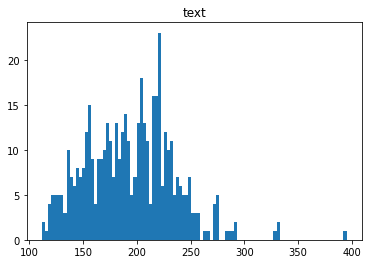

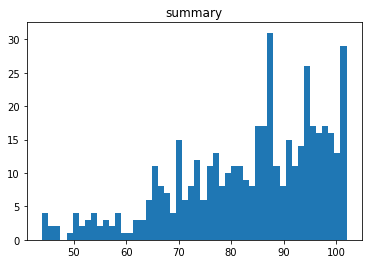

In [ ]:
art_len=[len(i.split()) for i in x_tr]
sum_len=[len(i.split()) for i in y_tr]
plt.hist(art_len,bins=100)
plt.title('text')
plt.show()
plt.hist(sum_len,bins=50)
plt.title('summary')
plt.show()

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer() 
x_tknizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* total_count gives the size of vocabulary (which means every unique words in the text)

* count gives me the no. of rare words whose count falls below threshold

* total_count - count gives me the top most common words

In [ ]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in x_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 68.75819441843042
Total Coverage of rare words: 12.138696799808033


In [ ]:

#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer(num_words=total_count-count) 
x_tknizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tknizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tknizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  len(x_tknizer.word_index) + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 10679


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* total_count gives the size of vocabulary (which means every unique words in the text)

* count gives me the no. of rare words whose count falls below threshold

* total_count - count gives me the top most common words

In [ ]:
#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer()   
y_tknizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 82.94621026894865
Total Coverage of rare words: 24.022483493286863


In [ ]:
#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer(num_words=total_count-count) 
y_tknizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tknizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tknizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   len(y_tknizer.word_index) +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 6545


We will now delete "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [ ]:
ind=[]
for i in range(len(y_tr)):
    count=0
    for j in y_tr[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    count=0
    for j in y_val[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
!wget 'http://nlp.stanford.edu/data/glove.6B.zip'
!unzip '/content/glove.6B.zip'

--2022-04-11 15:18:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-11 15:18:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-11 15:18:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# GLOVE_DIR = path for glove.6B.100d.txt
def glove_100d_dictionary(GLOVE_DIR):
  embeddings_index = {}
  f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  return embeddings_index

In [ ]:
import os
embeddings_index = {}
f = open(os.path.join('/content', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_index = x_tknizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(10679, 100)

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input,LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,weights=[embedding_matrix],trainable=True)(encoder_inputs)

#encoder GRU 1
encoder_GRU1 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1 = encoder_GRU1(enc_emb)

#encoder GRU 2
encoder_GRU2 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2= encoder_GRU2(encoder_output1)

#encoder GRU 3
encoder_GRU3=GRU(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h= encoder_GRU3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(x_voc, embedding_dim,weights=[embedding_matrix],trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_GRU = GRU(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state = decoder_GRU(dec_emb,initial_state=[state_h])

#dense layer - softmax
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     1067900     ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      [(None, 500, 300),   361800      ['embedding[0][0]']              
                                 (None, 300)]                                                     
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                           

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=1,callbacks=[es],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


8/8 [==============================] - 87s 10s/step - loss: 4.7230 - accuracy: 0.3481 - val_loss: 4.1154 - val_accuracy: 0.3821


###Save model weights

In [ ]:
model.save_weights('/content/drive/MyDrive/NLP/fitted_model_uni.h5')

###Load model weights

In [ ]:
model = model.load_weights('/content/drive/MyDrive/NLP/fitted_model_uni.h5')

**Plot model learning curve**

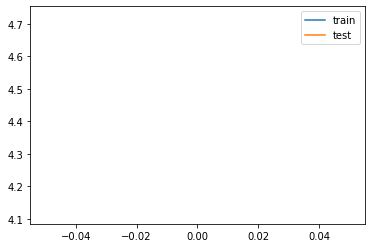

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tknizer.index_word
reverse_source_word_index=x_tknizer.index_word
target_word_index=y_tknizer.word_index

In [ ]:
# Encoding our input seq for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h])

decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 

# initial states from the previous time step
decoder_outputs2, state_h2 = decoder_GRU(dec_emb2, initial_state=[decoder_state_input_h])

# softmax for probability
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h],
    [decoder_outputs2] + [state_h2])

In [ ]:
import random
def decode_sequence(input_seq,k):
    # Encode the input as state vectors.
    e_out, e_h = encoder_model.predict(input_seq)
    i=0
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h = decoder_model.predict([target_seq] + [e_out, e_h])
        # print(output_tokens)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        if sampled_token_index not in reverse_target_word_index.keys():
          sampled_token=sequence_to_summary(y_tr[k])
          # print("string is ",sequence_to_summary(y_tr[k]))
        else:
          sampled_token = reverse_target_word_index[sampled_token_index]
        i+=1
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h= h

    return decoded_sentence


In [ ]:
def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

###Predict and print summaries from model

In [ ]:
for i in range(0,1):
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",(sequence_to_summary(y_tr[i])).replace('start', '').replace('end', ''))
    print("Predicted summary:",(decode_sequence(x_tr[i].reshape(1,max_text_len),i)).replace('start', '').replace('end', ''))
    print("\n")

Review: isinbayeva heads for birmingham olympic champion isinbayeva has confirmed she will take part in the 2005 norwich union grand prix in birmingham on 18 february knows how much enjoy competing in britain always seem to break records there said isinbayeva as olympic champion there will be more attention on me this year but hopefully can with another record in birmingham kelly holmes and carolina kluft are among other athens winners competing the organisers are hoping that isinbayeva main rival fellow russian will also take part in the event the pair had battle in athens which ended with isinbayeva finally world record of 4 to claim the gold medal isinbayeva 22 has set 10 world records in the three of which have come on british 
Original summary:  olympic champion has confirmed she will take part in the 2005 norwich union grand prix in birmingham on 18 february 22 has set 10 world records in the three of which have come on british the had battle in athens which ed with world record 

#Calculating scores

###Function to calculate BLEU, GLEU and METEOR scores

In [ ]:
print(reverse_target_word_index)

{1: 'the', 2: 'in', 3: 'to', 4: 'of', 5: 'and', 6: 'end', 7: 'start', 8: 'sostok', 9: 'eostok', 10: 'for', 11: 'said', 12: 'has', 13: 'was', 14: 'on', 15: 'is', 16: 'at', 17: 'with', 18: 'by', 19: 'it', 20: 'that', 21: 'will', 22: 'he', 23: 'be', 24: 'year', 25: 'from', 26: 'as', 27: 'his', 28: 'been', 29: 'an', 30: 'have', 31: 'had', 32: 'but', 33: 'last', 34: 'after', 35: 'us', 36: 'are', 37: 'its', 38: 'which', 39: 'film', 40: 'also', 41: 'who', 42: 'up', 43: 'not', 44: 'their', 45: 'best', 46: 'first', 47: 'this', 48: 'would', 49: 'two', 50: '6', 51: 'world', 52: 'mr', 53: 'one', 54: 'more', 55: 'new', 56: 'out', 57: 'her', 58: 'we', 59: 'were', 60: 'they', 61: 'than', 62: '1', 63: 'over', 64: 'against', 65: 'uk', 66: 'she', 67: 'won', 68: '2004', 69: 'a', 70: 'second', 71: 'number', 72: 'years', 73: 'three', 74: 'firm', 75: 'while', 76: 'if', 77: 'could', 78: 'win', 79: 'time', 80: 'sales', 81: 'about', 82: 'game', 83: 'now', 84: '3', 85: 'month', 86: 'when', 87: '000', 88: 'all',

In [ ]:
nltk.download('wordnet')
!pip install rouge
from rouge import Rouge

rouge = Rouge()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def calculate_rogue(src_trg, pred_trg):
      
  #cut off <eos> token
  pred_trg = pred_trg[:-6]

  
  if (len(pred_trg) == 0):
    rogue_score = 0.0
  else:
    s = rouge.get_scores(pred_trg, src_trg, avg= True)
    rogue_score = s['rouge-1']['f']
    
  return rogue_score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.meteor_score import meteor_score

def calculate_scores(N=100):    
    bscore=0;gscore=0;mscore=0
    for i in range(N):
        ref=sequence_to_summary(y_tr[i])
        hypo=decode_sequence(x_tr[i].reshape(1,max_text_len),i)
        bscore+=sentence_bleu([ref],hypo)
        gscore+=sentence_gleu([ref],hypo)
        # mscore+=meteor_score([ref],hypo)
    print("Average scores - BLEU:%.4f ROGUE:%.4f METEOR:%.4f"%(bscore/N,gscore/N,mscore/N))

###Calculating score metrics for first 100

In [ ]:
calculate_scores()

BLEU:0.4512 GLEU:0.4512 METEOR:0.0000
